In [ ]:
!pip install contractions
!pip install fuzzywuzzy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , confusion_matrix

import contractions

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/quara duplicate questions pair.csv')
df.shape

(404290, 6)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [ ]:
df.dropna(inplace = True)

In [ ]:
# df = df.sample(10000,random_state = 26)[['question1',	'question2',	'is_duplicate']]
df = df[['question1',	'question2',	'is_duplicate']]
df.shape

(404287, 3)

<Axes: ylabel='count'>

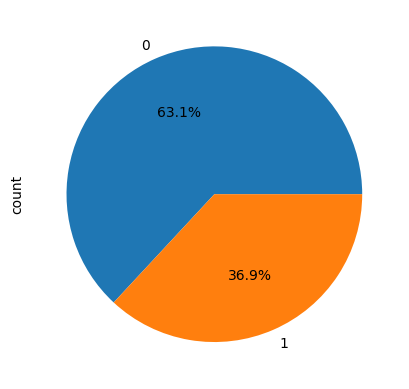

In [ ]:
df['is_duplicate'].value_counts().plot(kind = 'pie' , autopct = '%0.1f%%')

data is **Imbalanced**

# expanding short words   
like what's --> what is  
i'm --> i am


In [ ]:
contractions.fix("i'm a boy. and i'll go markete,")

'i am a boy. and i will go markete,'

In [ ]:
df['question1'].iloc[0]

'What is the step by step guide to invest in share market in india?'

In [ ]:
df['question1'] = df['question1'].apply(lambda text : contractions.fix(text))
df['question2'] = df['question2'].apply(lambda text : contractions.fix(text))

# Text Preprocessing

In [ ]:
all_q = pd.Series(df['question1'].tolist() + df['question2'].tolist(),name = 'question' )
all_q.shape

(808574,)

In [ ]:
all_q.head()

,question
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."


### Lowercasing and white spaces

In [ ]:
all_q = all_q.str.lower().str.strip()

### Removing HTML tags

In [ ]:
all_q = all_q.apply(lambda x : re.sub('<.*?>' , '' , x))

In [ ]:
all_q.head(1)

,question
0,what is the step by step guide to invest in sh...


In [ ]:
df['question1'] = df['question1'].str.lower()
df['question2'] = df['question2'].str.lower()

In [ ]:
df.head()

,question1,question2,is_duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0
4,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0


# Creating Custom Features

In [ ]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [ ]:
df['q1_words'] = df['question1'].apply(lambda text : len(text.split(" ")) )
df['q2_words'] = df['question2'].apply(lambda text : len(text.split(" ")) )

In [ ]:
def word_common(row):
  word1 = set(row['question1'].split(" "))
  word2 = set(row['question2'].split(" "))

  return len(word1.intersection(word2))

In [ ]:
df['common_words'] = df.apply(word_common ,axis = 1)

In [ ]:
df['word total'] = df['q1_len'] + df['q2_len']

In [ ]:
df['word share'] = df['common_words'] / df['word total']

In [ ]:
stop_words = stopwords.words('english')

def find_word_tokenize(text):
  stop_words = stopwords.words('english')

  words = word_tokenize(text)

  return len([word for word in words if word in stop_words])

In [ ]:
df['q1_stopwords'] = df['question1'].apply(find_word_tokenize)
df['q2_stopwords'] = df['question2'].apply(find_word_tokenize)

In [ ]:
df.head(2)

,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,word total,word share,q1_stopwords,q2_stopwords
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,10,123,0.081301,7,6
1,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,4,139,0.028777,4,4


<Axes: ylabel='Frequency'>

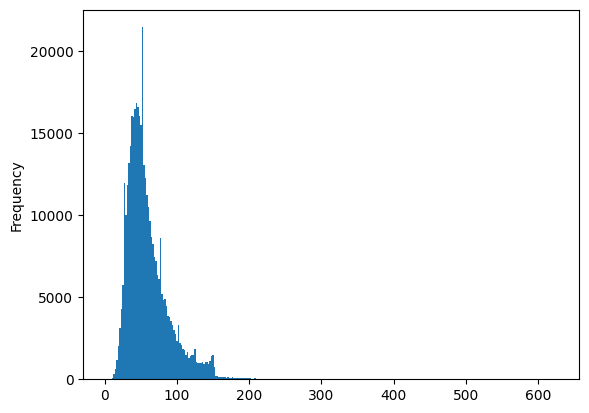

In [ ]:
df['q1_len'].plot(kind = 'hist' , bins = 300)

<Axes: ylabel='Frequency'>

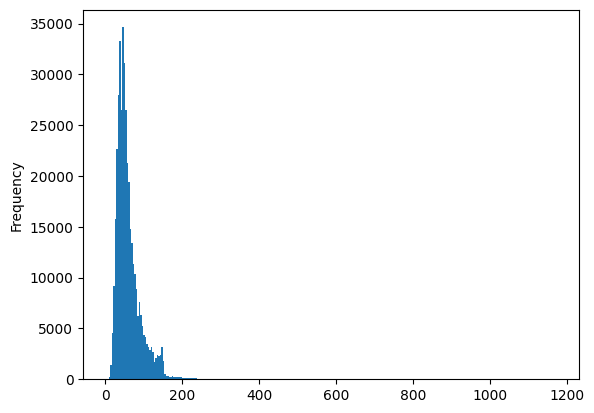

In [ ]:
df['q2_len'].plot(kind = 'hist',bins = 300)

<Axes: ylabel='Frequency'>

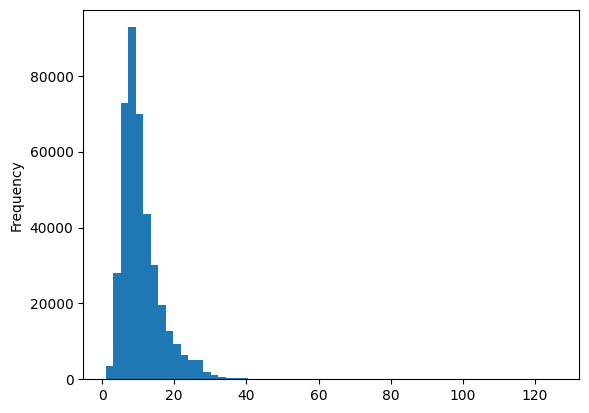

In [ ]:
df['q1_words'].plot(kind = 'hist',bins = 60)

<Axes: ylabel='Frequency'>

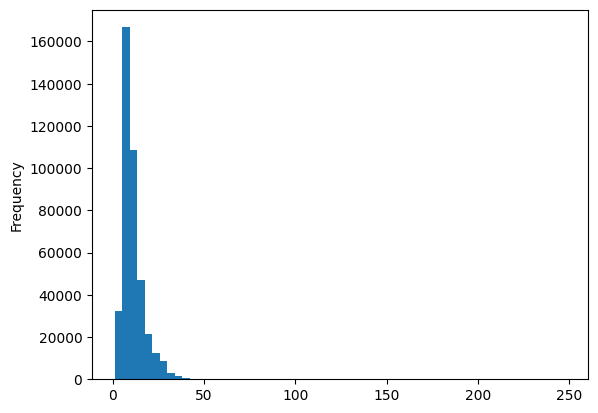

In [ ]:
df['q2_words'].plot(kind = 'hist' , bins = 60)

<Axes: ylabel='Frequency'>

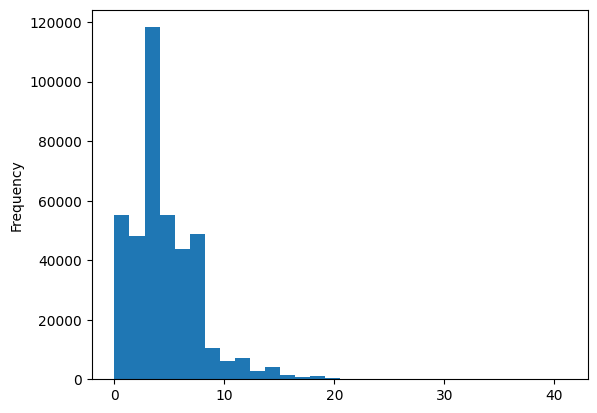

In [ ]:
df['common_words'].plot(kind = 'hist',bins = 30)

<Axes: ylabel='Frequency'>

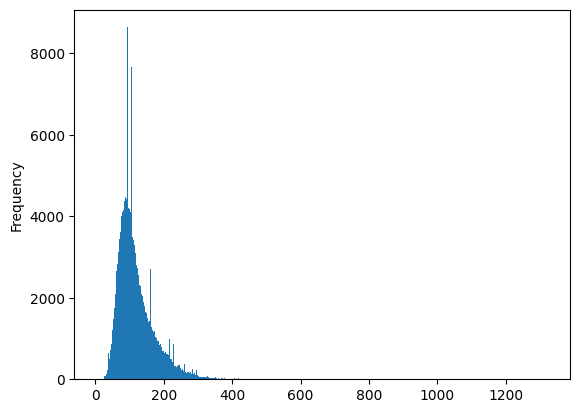

In [ ]:
df['word total'].plot(kind = 'hist', bins = 1200)

<Axes: ylabel='Frequency'>

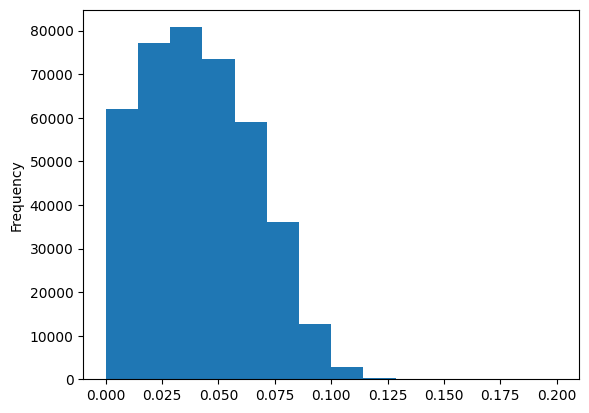

In [ ]:
df['word share'].plot(kind = 'hist' , bins =14 )

<Axes: ylabel='Frequency'>

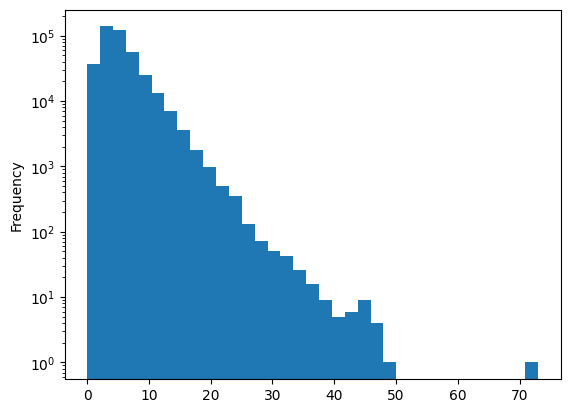

In [ ]:
df['q1_stopwords'].plot(kind = 'hist' , log=True , bins = 35)

<Axes: ylabel='Frequency'>

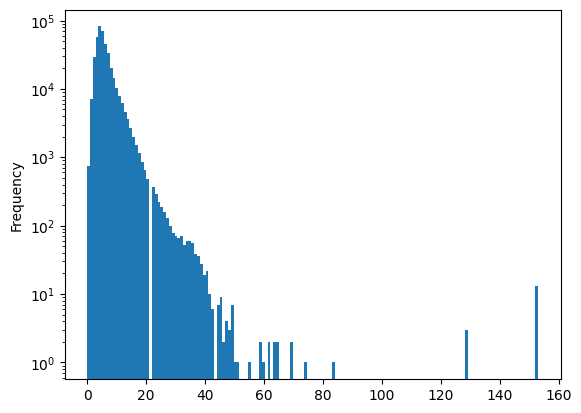

In [ ]:
df['q2_stopwords'].plot(kind = 'hist' , log = True , bins = 160)

<ipython-input-137-2130212efd18>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q1_len'],label='non duplicate')
<ipython-input-137-2130212efd18>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q1_len'],label='duplicate')


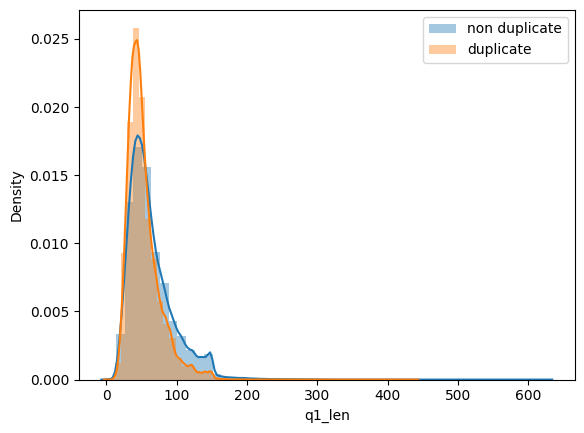

In [ ]:
# question 1 length
sns.distplot(df[df['is_duplicate'] == 0]['q1_len'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q1_len'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-138-a8ee4ef86212>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q2_len'],label='non duplicate')
<ipython-input-138-a8ee4ef86212>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q2_len'],label='duplicate')


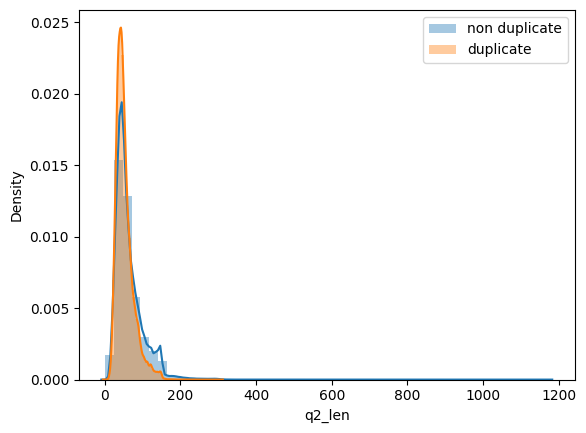

In [ ]:
# question 2 length
sns.distplot(df[df['is_duplicate'] == 0]['q2_len'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q2_len'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-139-e3b671603ed2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q1_words'],label='non duplicate')
<ipython-input-139-e3b671603ed2>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q1_words'],label='duplicate')


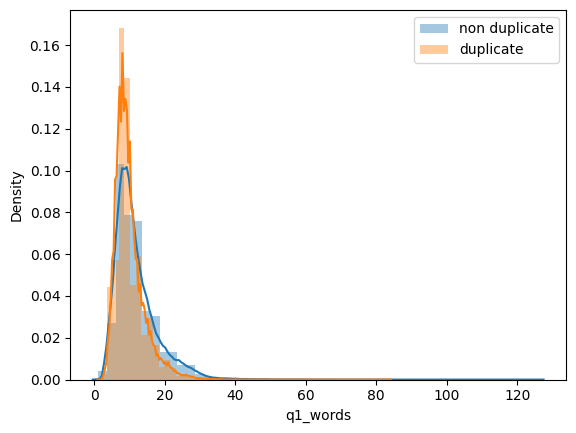

In [ ]:
# question 1 words
sns.distplot(df[df['is_duplicate'] == 0]['q1_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q1_words'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-140-ade65a244475>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q2_words'],label='non duplicate')
<ipython-input-140-ade65a244475>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q2_words'],label='duplicate')


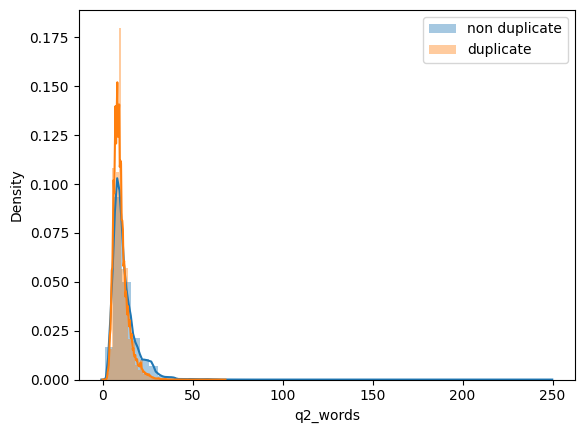

In [ ]:
# question 2 words
sns.distplot(df[df['is_duplicate'] == 0]['q2_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q2_words'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-141-9fbba4a7cb89>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['common_words'],label='non duplicate')
<ipython-input-141-9fbba4a7cb89>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['common_words'],label='duplicate')


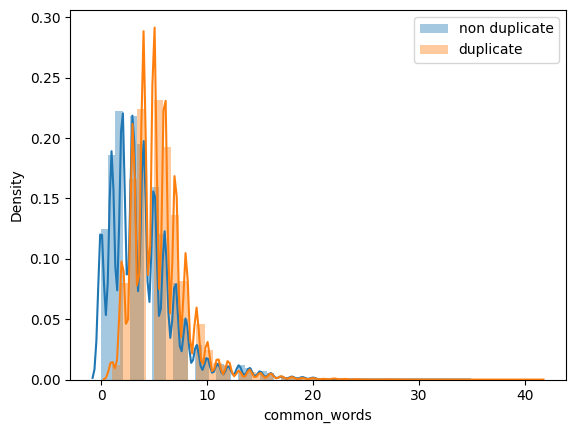

In [ ]:
# common words
sns.distplot(df[df['is_duplicate'] == 0]['common_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['common_words'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-142-317202ea3b33>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['word total'],label='non duplicate')
<ipython-input-142-317202ea3b33>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['word total'],label='duplicate')


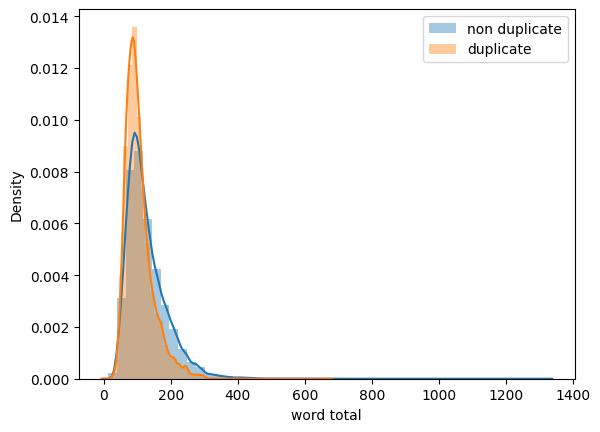

In [ ]:
# total words
sns.distplot(df[df['is_duplicate'] == 0]['word total'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word total'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-143-3181b98bf72a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['word share'],label='non duplicate')
<ipython-input-143-3181b98bf72a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['word share'],label='duplicate')


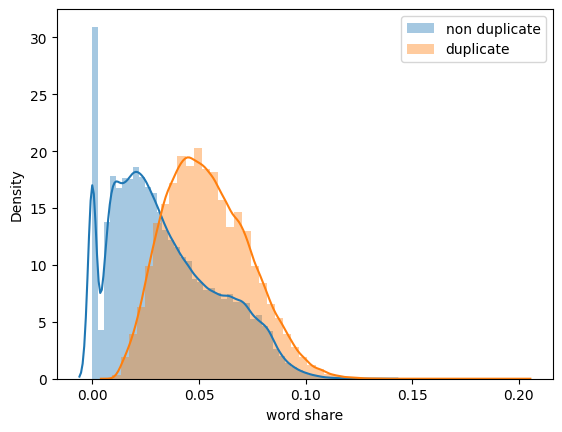

In [ ]:
# word share
sns.distplot(df[df['is_duplicate'] == 0]['word share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word share'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-144-66103a22b2da>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q1_stopwords'],label='non duplicate')
<ipython-input-144-66103a22b2da>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q1_stopwords'],label='duplicate')


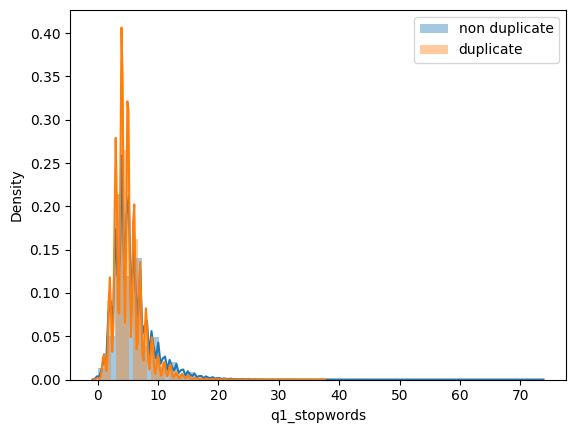

In [ ]:
# question 1 stop words
sns.distplot(df[df['is_duplicate'] == 0]['q1_stopwords'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q1_stopwords'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-145-00b60b0f2515>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q2_stopwords'],label='non duplicate')
<ipython-input-145-00b60b0f2515>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q2_stopwords'],label='duplicate')


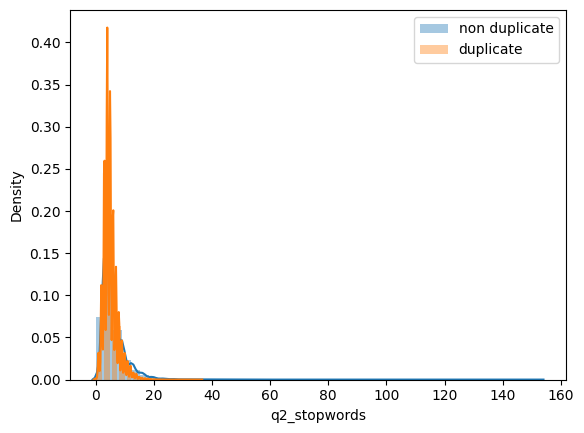

In [ ]:
# question 2 stop words
sns.distplot(df[df['is_duplicate'] == 0]['q2_stopwords'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q2_stopwords'],label='duplicate')
plt.legend()
plt.show()

<p color = 'green' > after creating some custom features we got 2.3% of accuracy score improvement ,  
Now it become 74.35%

## token Features

#  Advanced Features
## 1. Token Features
- `cwc_min` : This is the ratio of the number of common words to the length of the smaller question

- `cwc_max` : This is the ratio of the number of common words to the length of the larger question  

- `csc_min` : This is the ratio of the number of common stop words to the smaller stop word count among the two questions  

- `csc_max` : This is the ratio of the number of common stop words to the larger stop word count among the two questions  

- `ctc_min`: This is the ratio of the number of common tokens to the smaller token count among the two questions  

- `ctc_max` : This is the ratio of the number of common tokens to the larger token count among the two questions  

- `last_word_eq`: 1 if the last word in the two questions is same, 0 otherwise  

- `first_word_eq`: 1 if the first word in the two questions is same, 0 otherwise  

## 2. Length Based Features
- `mean_len`: Mean of the length of the two questions (number of words)  

- `abs_len_diff`: Absolute difference between the length of the two questions (number of words)  

- `longest_substr_ratio`: Ratio of the length of the longest substring among the two questions to the length of the smaller question  

## 3. Fuzzy Features
- `fuzz_ratio`: fuzz_ratio score from fuzzywuzzy  

- `fuzz_partial_ratio`: fuzz_partial_ratio from fuzzywuzzy  

- `token_sort_ratio:` token_sort_ratio from fuzzywuzzy  

- `token_set_ratio`: token_set_ratio from fuzzywuzzy

## Token features

In [ ]:
def find_cwc_min(row):
  return row['common_words'] / min(row['q1_len'] , row['q2_len'])

In [ ]:
df['cwc_min'] = df.apply(find_cwc_min ,axis = 1)

In [ ]:
def find_cwc_max(row):
  return row['common_words'] / max(row['q1_len'] , row['q2_len'])

In [ ]:
df['cwc_max'] = df.apply(find_cwc_max, axis = 1)

In [ ]:
def find_csc_min(row):
  return row['common_words'] / (min(row['q1_stopwords'] , row['q2_stopwords']) + 0.000001)

In [ ]:
df['csc_min'] = df.apply(find_csc_min , axis = 1)

In [ ]:
def find_csc_max(row):
  return row['common_words'] / (max(row['q1_stopwords'] , row['q2_stopwords']) + 0.000001)

In [ ]:
df['csc_max'] = df.apply(find_csc_max , axis = 1)

In [ ]:
def find_ctc_min(row):
  return row['common_words'] / min(row['q1_len'] , row['q2_len'])

In [ ]:
df['ctc_min'] = df.apply(find_ctc_min , axis = 1)

In [ ]:
def find_ctc_max(row):
  return row['common_words'] / max(row['q1_len'] , row['q2_len'])

In [ ]:
df['ctc_max'] = df.apply(find_ctc_max , axis = 1)

In [ ]:
def find_first_word_equal(row):
  return 1 if row['question1'].split(" ")[0] == row ['question2'].split(" ")[0] else 0

In [ ]:
df['first_word_eq'] = df.apply(find_first_word_equal , axis = 1)

In [ ]:
def find_last_word_equal(row):
  return 1 if row['question1'].split(" ")[-1] == row ['question2'].split(" ")[-1] else 0

In [ ]:
df['last_word_eq'] = df.apply(find_last_word_equal , axis = 1)

In [ ]:
df.head(2)

,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,word total,word share,q1_stopwords,q2_stopwords,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,10,123,0.081301,7,6,0.175439,0.151515,1.666666,1.428571,0.175439,0.151515,1,0
1,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,4,139,0.028777,4,4,0.078431,0.045455,1.000000,1.000000,0.078431,0.045455,1,0


<Axes: ylabel='Frequency'>

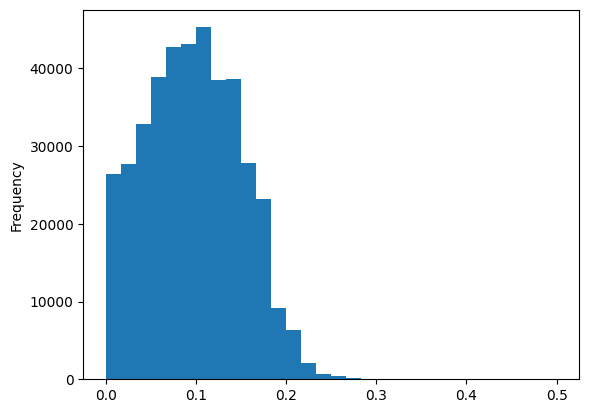

In [ ]:
df['cwc_min'].plot(kind = 'hist' , bins = 30)

<Axes: ylabel='Frequency'>

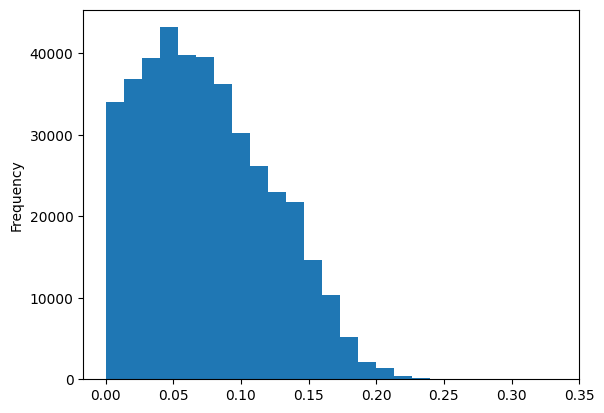

In [ ]:
df['cwc_max'].plot(kind = 'hist' , bins = 25)

<Axes: ylabel='Frequency'>

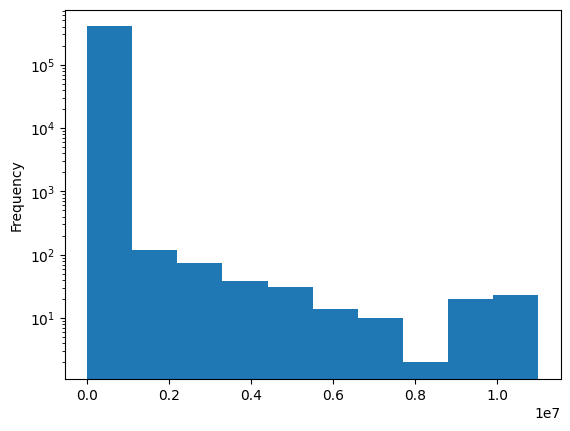

In [ ]:
df['csc_min'].plot(kind = 'hist',log= True,bins = 10)

<Axes: ylabel='Frequency'>

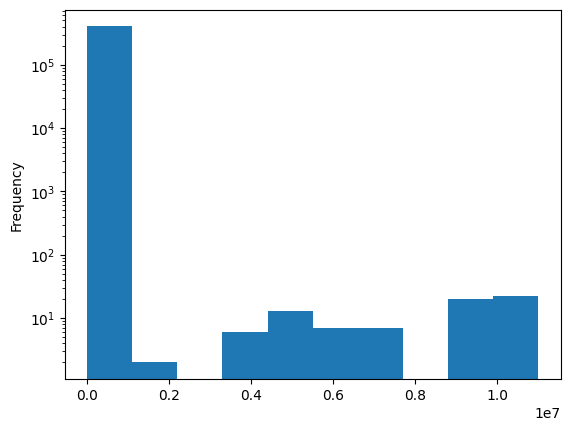

In [ ]:
df['csc_max'].plot(kind = 'hist',log = True, bins = 10)

<Axes: ylabel='Frequency'>

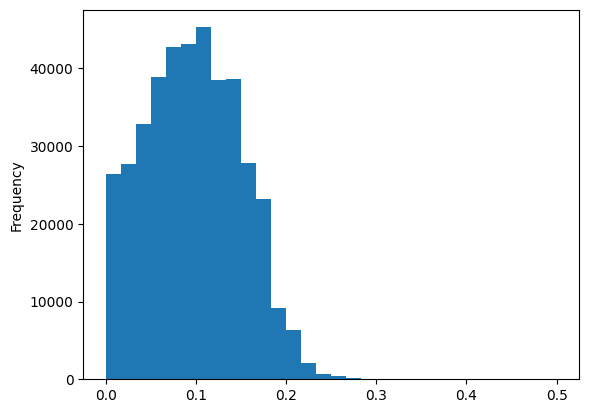

In [ ]:
df['ctc_min'].plot(kind='hist' , bins = 30)

<Axes: ylabel='Frequency'>

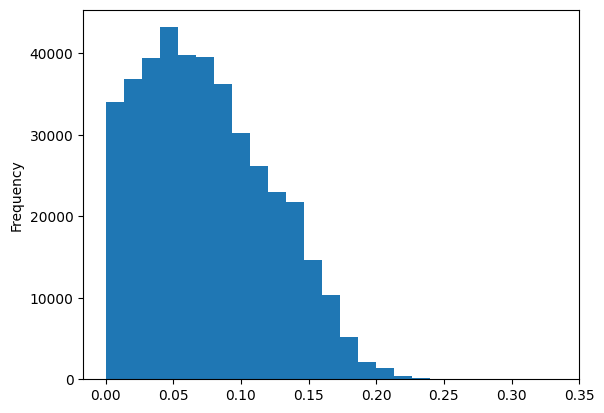

In [ ]:
df['ctc_max'].plot(kind = 'hist' , bins = 25)

**almost all features are in RIGHT skewed , so normize**

<Axes: ylabel='count'>

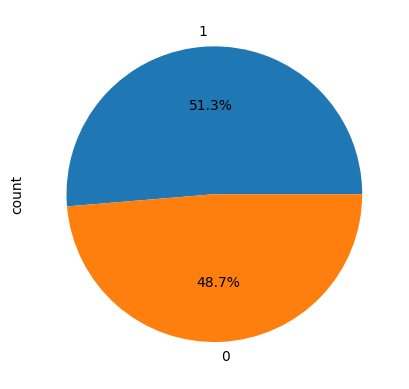

In [ ]:
df['first_word_eq'].value_counts().plot(kind = 'pie' , autopct = '%0.1f%%')

<Axes: ylabel='count'>

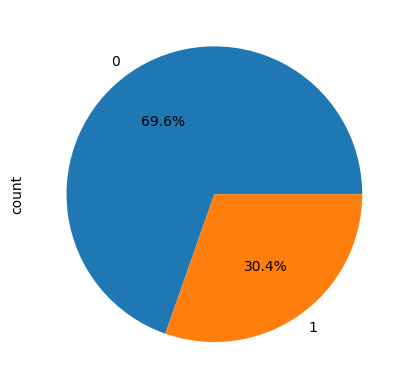

In [ ]:
df['last_word_eq'].value_counts().plot(kind = 'pie' , autopct = '%0.1f%%')

## Length based feature

In [ ]:
df['mean_len'] = (df['q1_words'] + df['q2_words']) / 2

In [ ]:
df['abs_len_diff'] = abs(df['q1_words'] - df['q2_words'])

<Axes: ylabel='Frequency'>

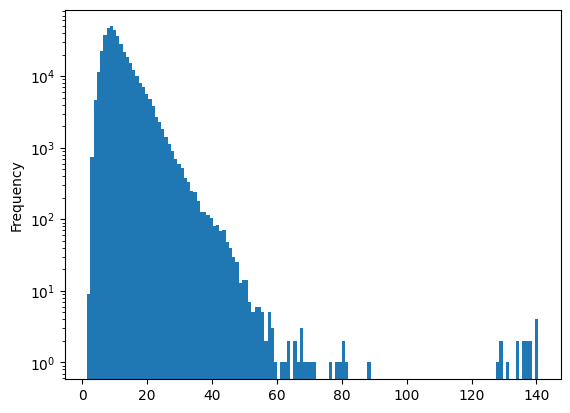

In [ ]:
df['mean_len'].plot(kind = 'hist' , log = True , bins = 140)

<Axes: ylabel='Frequency'>

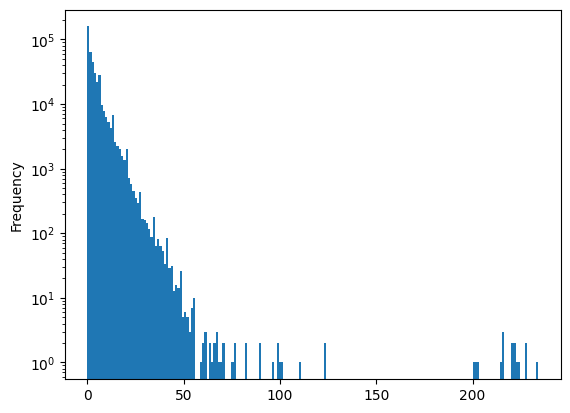

In [ ]:
df['abs_len_diff'].plot(kind = 'hist' , log = True , bins = 200)

**right skewed**

## fuzzywuzzy features

fuzzywuzzy reference link : https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [ ]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))
df.shape

(404287, 26)

In [ ]:
df.head(1)

,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,word total,word share,...,ctc_min,ctc_max,first_word_eq,last_word_eq,mean_len,abs_len_diff,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,10,123,0.081301,...,0.175439,0.151515,1,0,13.0,2,93,98,93,100


#### Normalization

In [ ]:
df.columns[2:]

Index(['is_duplicate', 'q1_len', 'q2_len', 'q1_words', 'q2_words',
       'common_words', 'word total', 'word share', 'q1_stopwords',
       'q2_stopwords', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'first_word_eq', 'last_word_eq', 'mean_len', 'abs_len_diff',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio',
       'token_set_ratio'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_scaler = MinMaxScaler()

scaled_values = min_scaler.fit_transform(df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio']])
scaled_values

array([[3.50877193e-01, 4.54545455e-01, 1.51515126e-07, ...,
        9.30000000e-01, 9.30000000e-01, 9.80000000e-01],
       [1.56862745e-01, 1.36363636e-01, 9.09090682e-08, ...,
        6.30000000e-01, 6.60000000e-01, 7.50000000e-01],
       [1.35593220e-01, 1.64383562e-01, 7.27272582e-08, ...,
        6.30000000e-01, 4.30000000e-01, 4.70000000e-01],
       ...,
       [3.52941176e-01, 5.00000000e-01, 1.36363568e-07, ...,
        7.90000000e-01, 7.90000000e-01, 7.60000000e-01],
       [2.12765957e-02, 2.36220472e-02, 1.13636349e-08, ...,
        3.50000000e-01, 3.00000000e-01, 3.40000000e-01],
       [4.32432432e-01, 5.33333333e-01, 1.45454516e-07, ...,
        9.00000000e-01, 9.00000000e-01, 8.60000000e-01]])

In [ ]:
scaled_values.shape

(404287, 14)

In [ ]:
scale_df = pd.DataFrame(scaled_values , index = df.index , columns = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio'])
scale_df.shape

(404287, 14)

In [ ]:
scale_df.head(1)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0.350877,0.454545,1.515151e-07,1.298701e-07,0.350877,0.454545,0.0,1.0,0.008547,0.082734,1.0,0.93,0.93,0.98


In [ ]:
new_df = pd.merge(df[['is_duplicate', 'q1_len', 'q2_len', 'q1_words', 'q2_words','common_words', 'word total', 'word share', 'q1_stopwords','q2_stopwords']] , scale_df , left_index = True , right_index = True)
new_df.shape

(404287, 24)

In [ ]:
new_df.head(1)

,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,word total,word share,q1_stopwords,q2_stopwords,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,66,57,14,12,10,123,0.081301,7,6,...,0.350877,0.454545,0.0,1.0,0.008547,0.082734,1.0,0.93,0.93,0.98


# Word 2 vec

In [ ]:
df.columns

Index(['question1', 'question2', 'is_duplicate', 'q1_len', 'q2_len',
       'q1_words', 'q2_words', 'common_words', 'word total', 'word share',
       'q1_stopwords', 'q2_stopwords', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'first_word_eq', 'last_word_eq',
       'mean_len', 'abs_len_diff', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

In [ ]:
import pickle
from gensim.utils import simple_preprocess

Word2Vec_model = pickle.load(open('Word2Vec_model.pkl' , 'rb'))

In [ ]:
def find_word_2_vec(Word2Vec_model , question):

  word_vectors = [Word2Vec_model.wv[word] for word in simple_preprocess(question) if word in Word2Vec_model.wv]
  # print(word_vectors)

  if len(word_vectors) > 0 :
    # making all word vectors to MEAN of all word vectors for that sentence
    return np.mean(word_vectors , axis = 0)
  else :
    # Handle the case where no word in the sentence exists in the model's vocabulary
    return np.zeros(Word2Vec_model.vector_size)

In [ ]:
q1_w2v = [find_word_2_vec(Word2Vec_model , question) for question in df['question1']]
q2_w2v = [find_word_2_vec(Word2Vec_model , question) for question in df['question2']]

In [ ]:
final_df = pd.merge(df.iloc[: , 2:] , pd.DataFrame(np.hstack((q1_w2v , q2_w2v)) , index = new_df.index)  , left_index = True , right_index = True)
final_df

,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,word total,word share,q1_stopwords,q2_stopwords,...,190,191,192,193,194,195,196,197,198,199
0,0,66,57,14,12,10,123,0.081301,7,6,...,-1.445208,-0.626956,0.121536,-0.559510,-0.137868,0.448912,0.255129,-0.629437,-0.007917,-0.142750
1,0,51,88,8,13,4,139,0.028777,4,4,...,-0.999219,-0.536418,0.782368,0.444509,-0.722811,-0.382210,0.474839,-0.351381,0.176559,-0.087681
2,0,73,59,14,10,4,132,0.030303,8,5,...,-0.745643,-0.653132,-0.019536,-0.378900,0.507797,0.156073,0.328818,-0.204175,0.727581,-0.271839
3,0,50,65,11,9,0,115,0.000000,8,4,...,-1.042573,-0.812904,-0.096672,-0.914025,0.229552,-0.858153,-0.088723,0.412434,-0.216609,-0.078248
4,0,76,39,13,7,2,115,0.017391,3,2,...,-1.045467,-0.769117,1.367996,1.602781,-0.986793,-0.225457,0.650943,0.363885,0.657752,-0.595058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,0,85,79,14,13,11,164,0.067073,7,6,...,-1.456613,-0.060530,0.777158,-0.539973,0.799074,0.294204,-0.050003,-1.191963,0.098667,-0.389073
404286,1,41,42,8,9,5,83,0.060241,5,6,...,-0.905571,-0.745192,1.166977,0.870564,0.041289,-0.477756,0.337947,0.147735,-0.795321,0.202291
404287,0,17,18,4,4,3,35,0.085714,2,3,...,-1.085511,-0.899876,-0.041735,-0.694380,-0.117503,0.037765,0.713009,0.334371,-0.350198,0.287828
404288,0,94,127,17,25,1,221,0.004525,8,12,...,-1.143053,-0.042206,-0.536848,-0.009214,-1.194157,0.069241,0.487255,-0.400876,-0.261347,0.944204


In [ ]:
final_df.columns = final_df.columns.astype('str')

In [ ]:
final_df.to_csv('final_df.csv' , index = False)

In [ ]:
x = final_df.iloc[: , 1:]
y = final_df.iloc[:,0]
x_train , x_test , y_train , y_test = train_test_split(x, y  , test_size = 0.2 , random_state = 2)

rf = RandomForestClassifier(
                      n_estimators=100,          # 100 trees in the forest
                      max_depth=10,              # Trees can grow to a maximum depth of 10
                      min_samples_split=5,       # A node must have at least 5 samples to be split
                      min_samples_leaf=2,        # A leaf must have at least 2 samples
                      max_features='sqrt',       # Consider the square root of total features when splitting
                      bootstrap=True,            # Use bootstrap samples
                      oob_score=True,            # Use out-of-bag samples for evaluation
                      random_state=42,           # Set seed for reproducibility
                      class_weight='balanced',
                      n_jobs=-1                  # Use all available cores for parallelism
)

rf.fit(x_train , y_train)

print(accuracy_score(y_test , rf.predict(x_test)))
print(confusion_matrix(y_test , rf.predict(x_test)) , end = '\n\n')

0.7318137970268866
[[31775 19173]
 [ 2512 27398]]



In [ ]:
import pickle
pickle.dump(rf , open('rf.pkl' , 'wb'))

but this comes with bag of words , so i am going with that

In [ ]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
cv_scores = cross_val_score(rf, x, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())

Cross-validation scores:  [0.757  0.778  0.776  0.7585 0.767 ]
Mean cross-validation score:  0.7672999999999999
